In [2]:
import numpy as np
import numpy.ma as ma

from pyhdf.SD import SD,SDC

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [28]:
vname = 'data\CAL_LID_L2_VFM-Standard-V4-21.2021-12-14T19-03-09ZN.hdf' #feature mask
vfile = SD(vname,SDC.READ)
vfile.datasets()

{'Profile_ID': (('fakeDim0', 'fakeDim1'), (3680, 1), 24, 0),
 'Latitude': (('fakeDim2', 'fakeDim3'), (3680, 1), 5, 1),
 'Longitude': (('fakeDim4', 'fakeDim5'), (3680, 1), 5, 2),
 'Profile_Time': (('fakeDim6', 'fakeDim7'), (3680, 1), 6, 3),
 'Profile_UTC_Time': (('fakeDim8', 'fakeDim9'), (3680, 1), 6, 4),
 'Day_Night_Flag': (('fakeDim10', 'fakeDim11'), (3680, 1), 23, 5),
 'Land_Water_Mask': (('fakeDim12', 'fakeDim13'), (3680, 1), 20, 6),
 'Minimum_Laser_Energy_532': (('fakeDim14', 'fakeDim15'), (3680, 1), 5, 7),
 'Spacecraft_Position': (('fakeDim16', 'fakeDim17'), (3680, 3), 6, 8),
 'Feature_Classification_Flags': (('fakeDim18', 'fakeDim19'),
  (3680, 5515),
  23,
  9),
 'ssProfile_ID': (('fakeDim20', 'fakeDim21'), (55200, 1), 24, 10),
 'ssLatitude': (('fakeDim22', 'fakeDim23'), (55200, 1), 5, 11),
 'ssLongitude': (('fakeDim24', 'fakeDim25'), (55200, 1), 5, 12),
 'ssProfile_Time': (('fakeDim26', 'fakeDim27'), (55200, 1), 6, 13),
 'ssProfile_UTC_Time': (('fakeDim28', 'fakeDim29'), (55200

In [29]:
plat = vfile.select('Latitude').get()
plon = vfile.select('Longitude').get()
print(plat.shape, plon.shape)

plat_nidx = np.where(plat<37)[0][0]
plat_sidx = np.where(plat>22)[0][-1]

(3680, 1) (3680, 1)


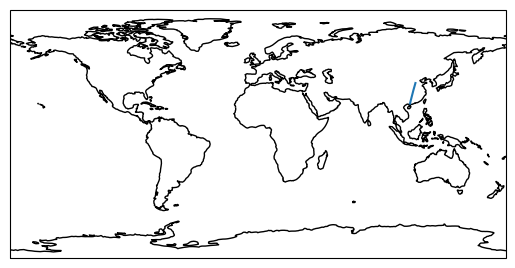

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())

ax.coastlines()
ax.plot(plon[plat_nidx:plat_sidx],plat[plat_nidx:plat_sidx],transform=ccrs.PlateCarree())
ax.set_extent([-180,180,-90,90])

#### Vertical features (supercooled cloud fraction)

In [31]:
vfile.datasets()

{'Profile_ID': (('fakeDim0', 'fakeDim1'), (3680, 1), 24, 0),
 'Latitude': (('fakeDim2', 'fakeDim3'), (3680, 1), 5, 1),
 'Longitude': (('fakeDim4', 'fakeDim5'), (3680, 1), 5, 2),
 'Profile_Time': (('fakeDim6', 'fakeDim7'), (3680, 1), 6, 3),
 'Profile_UTC_Time': (('fakeDim8', 'fakeDim9'), (3680, 1), 6, 4),
 'Day_Night_Flag': (('fakeDim10', 'fakeDim11'), (3680, 1), 23, 5),
 'Land_Water_Mask': (('fakeDim12', 'fakeDim13'), (3680, 1), 20, 6),
 'Minimum_Laser_Energy_532': (('fakeDim14', 'fakeDim15'), (3680, 1), 5, 7),
 'Spacecraft_Position': (('fakeDim16', 'fakeDim17'), (3680, 3), 6, 8),
 'Feature_Classification_Flags': (('fakeDim18', 'fakeDim19'),
  (3680, 5515),
  23,
  9),
 'ssProfile_ID': (('fakeDim20', 'fakeDim21'), (55200, 1), 24, 10),
 'ssLatitude': (('fakeDim22', 'fakeDim23'), (55200, 1), 5, 11),
 'ssLongitude': (('fakeDim24', 'fakeDim25'), (55200, 1), 5, 12),
 'ssProfile_Time': (('fakeDim26', 'fakeDim27'), (55200, 1), 6, 13),
 'ssProfile_UTC_Time': (('fakeDim28', 'fakeDim29'), (55200

In [32]:
vfile_fcf = vfile.select('Feature_Classification_Flags').get()[plat_nidx:plat_sidx,:]

In [33]:
vfile_fcf.shape

(333, 5515)

In [34]:
vfile0 = vfile_fcf[200,:]
vfile0_bits = []

for i in range(0,len(vfile0),1):
    val = vfile0[i]
    bin_ = bin(val)[2:].zfill(16)
    
    #Feature type
    ft = int(bin_[13:16],2)
    
    #Feature type QA
    ftqa = int(bin_[11:13],2)
    
    #Ice/Water phase
    ph = int(bin_[9:11],2)
    
    #Ice/water phase QA
    phqa = int(bin_[7:9],2)
    
    #Feature sub-type
    fst = int(bin_[4:7],2)
    
    #Feature sub-type QA
    fstqa = int(bin_[3],2)
    
    #Horizontal averaging required for detection (provides a coarse measure of feature backscatter intensity)
    ha = int(bin_[0:3],2)
    
    strg = str(ft) + str(ftqa) + str(ph) + str(phqa) + str(fst) + str(fstqa) + str(ha)
    
    vfile0_bits.append(strg)

In [35]:
for i in range(0,len(slf_layer),1):
    
    phase = []
    cloud_type = []
    
    for j in range(0,len(col_start),1):
        
        top_idx = col_start[j] + col_itv[i]
        bot_idx = col_start[j] + col_itv[i] + 1
        
        f_str_top = vfile0_bits[top_idx]
        f_str_bot = vfile0_bits[bot_idx]
        
        #Check if this profile is related to clouds
        if int(f_str_top[0]) == 2: #clouds + medium or higher confidence level
            p_top = int(f_str_top[2]) #Ice/water phase
            if int(f_str_top[5]) == 1: # Cloud sub-type
                ct_top = int(f_str_top[4])
            else:
                ct_top = np.nan
        else:
            p_top = np.nan
            ct_top = np.nan
            
        phase.append(p_top)
        cloud_type.append(ct_top)
        
        #To average between different resolutions (30m -> 60m)
        if int(f_str_bot[0]) == 2: #clouds + medium or higher confidence level
            p_bot = int(f_str_bot[2]) #Ice/water phase
            if int(f_str_bot[5]) == 1: # Cloud sub-type
                ct_bot = int(f_str_bot[4])
            else:
                ct_bot = np.nan
        else:
            p_bot = np.nan
            ct_bot = np.nan
            
        phase.append(p_bot)
        cloud_type.append(ct_bot)
        
    ice_c = 0
    water_c = 0 
    
    for m in range(0,len(phase),1):
        if phase[m] == 1 or phase[m] == 3:
            ice_c += 1
        if phase[m] == 2:
            water_c += 1
        else:
            pass
    
    if ice_c + water_c == 0:
        slf_layer[i] = np.nan
    else:
        slf = water_c/(ice_c + water_c)
        slf_layer[i] = slf
    
    print(ice_c,water_c)

NameError: name 'slf_layer' is not defined

NameError: name 'test' is not defined

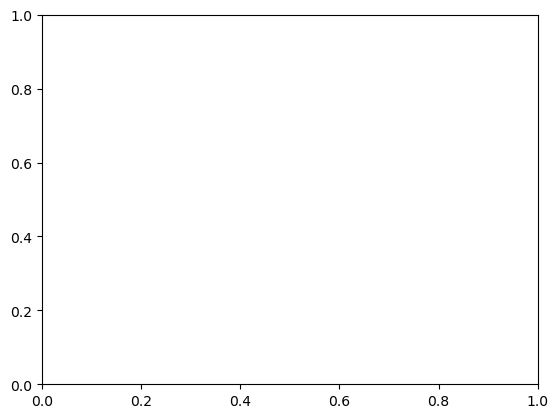

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for k in range(0,758,1):
    vfile = vfile_fcf[k,:]
    vfile_bits = []

    for m in range(0,len(vfile),1):
        val = vfile[m]
        bin_ = bin(val)[2:].zfill(16)
    
        #Feature type
        ft = int(bin_[13:16],2)
    
        #Feature type QA
        ftqa = int(bin_[11:13],2)
    
        #Ice/Water phase
        ph = int(bin_[9:11],2)
    
        #Ice/water phase QA
        phqa = int(bin_[7:9],2)
    
        #Feature sub-type
        fst = int(bin_[4:7],2)
    
        #Feature sub-type QA
        fstqa = int(bin_[3],2)
    
        #Horizontal averaging required for detection (provides a coarse measure of feature backscatter intensity)
        ha = int(bin_[0:3],2)
    
        strg = str(ft) + str(ftqa) + str(ph) + str(phqa) + str(fst) + str(fstqa) + str(ha)
    
        vfile_bits.append(strg)
    
    col_start = np.arange(1165,5226,290)
    col_itv = np.arange(0,289,2)
    slf_layer = np.empty([145])
    
    for i in range(0,len(slf_layer),1):
    
        phase = []
        cloud_type = []
    
        for j in range(0,len(col_start),1):
        
            top_idx = col_start[j] + col_itv[i]
            bot_idx = col_start[j] + col_itv[i] + 1
        
            f_str_top = vfile_bits[top_idx]
            f_str_bot = vfile_bits[bot_idx]
        
            #Check if this profile is related to clouds
            if int(f_str_top[0]) == 2 and int(f_str_top[1]) == 3 and int(f_str_top[3]) == 3: #clouds + medium or higher confidence level
                p_top = int(f_str_top[2]) #Ice/water phase
                if int(f_str_top[5]) == 1: # Cloud sub-type
                    ct_top = int(f_str_top[4])
                else:
                    ct_top = np.nan
            else:
                p_top = np.nan
                ct_top = np.nan
            
            phase.append(p_top)
            cloud_type.append(ct_top)
        
            #To average between different resolutions (30m -> 60m)
            if int(f_str_bot[0]) == 2 and int(f_str_bot[1]) == 3 and int(f_str_bot[3]) == 3: #clouds + medium or higher confidence level
                p_bot = int(f_str_bot[2]) #Ice/water phase
                if int(f_str_bot[5]) == 1: # Cloud sub-type
                    ct_bot = int(f_str_bot[4])
                else:
                    ct_bot = np.nan
            else:
                p_bot = np.nan
                ct_bot = np.nan
            
            phase.append(p_bot)
            cloud_type.append(ct_bot)
        
        ice_c = 0
        water_c = 0 
    
        for n in range(0,len(phase),1):
            if phase[n] == 1 or phase[n] == 3:
                ice_c += 1
            if phase[n] == 2:
                water_c += 1
            else:
                pass
    
        if ice_c + water_c <= 15:
            slf_layer[i] = np.nan
        else:
            slf = water_c/(ice_c + water_c)
            slf_layer[i] = slf
    
    ctemp = test[:,k]
    ax.scatter(ctemp[hgts<=8.2],slf_layer)

Slide show

In [26]:
low_atm = np.empty([290,15])

In [28]:
col_start = np.arange(1165,5226,290)
print(col_start.shape)

(15,)


In [29]:
for i in range(0,len(col_start),1):
    for j in range(0,290,1):
        idx = col_start[i] + j
        p_ft = vfile0_bits[idx][0]
        low_atm[j,i] = p_ft

In [32]:
hgts = np.arange(-0.5, 8.2,0.03)
print(hgts.shape)

(290,)


In [35]:
distance = np.arange(0,4.9,0.333)
print(distance.shape)

(15,)


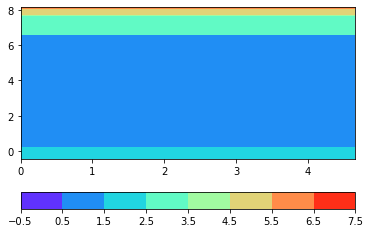

In [41]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
levs = np.arange(-0.5,8.5,1)

im = ax.contourf(distance,hgts,low_atm,levels=levs,cmap='rainbow')
cb = plt.colorbar(im, orientation='horizontal')

In [44]:
len(vfile_fcf)

758

In [72]:
atm_ft = np.empty([290,15*len(vfile_fcf)])

for m in range(0,len(vfile_fcf),1):
    
    vfile0 = vfile_fcf[m,:]
    vfile0_bits = []
    low_atm = np.empty([290,15])

    for n in range(0,len(vfile0),1):
        val = vfile0[n]
        bin_ = bin(val)[2:].zfill(16)
    
        #Feature type
        ft = int(bin_[13:16],2)
    
        #Feature type QA
        ftqa = int(bin_[11:13],2)
    
        #Ice/Water phase
        ph = int(bin_[9:11],2)
    
        #Ice/water phase QA
        phqa = int(bin_[7:9],2)
    
        #Feature sub-type
        fst = int(bin_[4:7],2)
    
        #Feature sub-type QA
        fstqa = int(bin_[3],2)
    
        #Horizontal averaging required for detection (provides a coarse measure of feature backscatter intensity)
        ha = int(bin_[0:3],2)
    
        strg = str(ft) + str(ftqa) + str(ph) + str(phqa) + str(fst) + str(fstqa) + str(ha)
    
        vfile0_bits.append(strg)
    
    for i in range(0,len(col_start),1):
        for j in range(0,290,1):
            idx = col_start[i] + j
            p_ft = vfile0_bits[idx][0]
            p_ftqa = vfile0_bits[idx][1]
            
            if p_ftqa in np.arange(2,5,1) and p_ftqa < 2:
                low_atm[j,i] = np.nan
            else:
                low_atm[j,i] = p_ft
                
    
    atm_ft[:,15*m:15*(m+1)] = low_atm

C:\Users\Xinyi\AppData\Local\Temp\ipykernel_23760\2802366140.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if p_ftqa in np.arange(2,5,1) and p_ftqa < 2:


In [73]:
atm_ft.shape

(290, 11370)

In [47]:
distance = np.arange(0,11370,1)

In [49]:
distance.shape

(11370,)

In [50]:
hgts.shape

(290,)

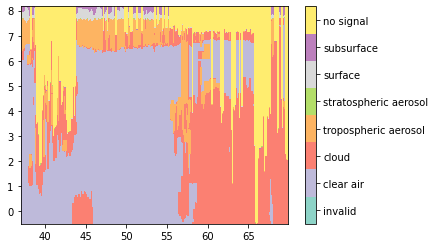

In [85]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
levs = np.arange(-0.5,8.5,1)

im = ax.contourf(lats,hgts,atm_ft,levels=levs,cmap='Set3')
ax.xaxis_inverted()


cb = plt.colorbar(im, orientation='vertical')
cb.set_ticks(np.arange(0,8,1))
cb.set_ticklabels(['invalid','clear air','cloud','tropospheric aerosol','stratospheric aerosol','surface','subsurface','no signal'])

In [60]:
plat[plat_nidx:plat_sidx,1].max()

-37.00233

In [61]:
plat[plat_nidx:plat_sidx,1].min()

-69.927475

In [59]:
758*15

11370

In [81]:
lats = np.arange(37.00233,69.927475,-(37.00233-69.927475)/11370)

In [82]:
lats.shape

(11370,)